# Exercice polynômes orthogonaux : application au cas de la déviation verticale de la poutre encastrée

## References
* http://openturns.github.io/openturns/master/user_manual/_generated/openturns.HermiteFactory.html

## La classe HermiteFactory

In [1]:
import openturns as ot
import numpy as np
import math

In [2]:
pofa = ot.HermiteFactory()

for k in range(5):
    print(pofa.build(k))

1
X
-0.707107 + 0.707107 * X^2
-1.22474 * X + 0.408248 * X^3
0.612372 - 1.22474 * X^2 + 0.204124 * X^4


In [3]:
pk = pofa.build(5)
pk

<openturns.orthogonalbasis.OrthogonalUniVariatePolynomial; proxy of <Swig Object of type 'OT::OrthogonalUniVariatePolynomial *' at 0x7fcc7160f9c0> >

In [4]:
pk.getDegree()

5

In [5]:
pk(3.0)

1.6431676725155

In [6]:
pk.getCoefficients()

class=Point name=Unnamed dimension=6 values=[0,1.36931,-0,-0.912871,0,0.0912871]

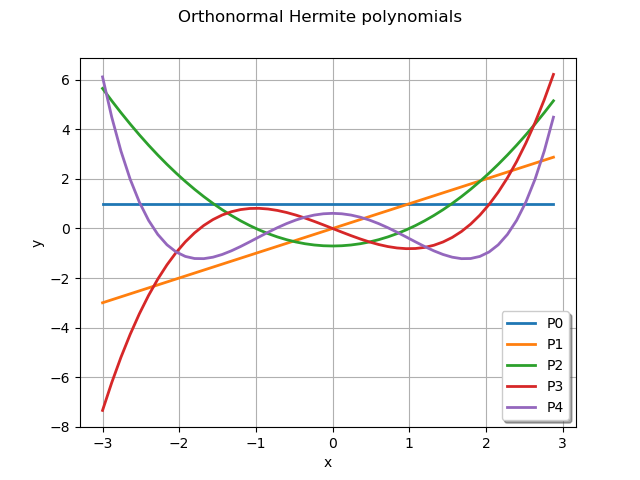

In [7]:
degreemax = 5
palette = ot.Drawable.BuildDefaultPalette(degreemax)
graph = ot.Graph("Orthonormal Hermite polynomials", "x", "y", True, "bottomright")
for k in range(degreemax):
    pk = pofa.build(k)
    curve = pk.draw(-3.0, 3.0, 50)
    curve.setLegends(["P%d" % (k)])
    graph.add(curve)
graph.setColors(palette)  # Add colors
graph

## Les polynômes sont orthonormés pour la densité

Dans OpenTURNS, les polynômes sont orthonormés pour la densité de probabilité. Par conséquent, ils ne sont généralement pas moniques, c'est à dire que le coefficient associé au monôme de plus haut degré n'est pas toujours égal à 1.

In [8]:
def linearSample(xmin, xmax, npoints):
    """Returns a sample created from a regular grid
    from xmin to xmax with npoints points."""
    step = (xmax - xmin) / (npoints - 1)
    rg = ot.RegularGrid(xmin, step, npoints)
    vertices = rg.getVertices()
    return vertices

Dans la boucle `for` suivante, on considère les polynômes d'Hermite de degré 0 à 5. Pour chaque degré, on affiche le coefficient du monôme de plus grand exposant que le facteur $1 / \sqrt{k!}$.  

In [10]:
print("Leading coefficient:")
for k in range(degreemax):
    pk = pofa.build(k)
    leadingCoeffOT = pk.getCoefficients()[-1]
    leadingCoeffReference = 1.0 / np.sqrt(math.factorial(k))
    print(f"OT = {leadingCoeffOT:.4f}, ref. = {leadingCoeffReference:.4f}")

Leading coefficient:
OT = 1.0000, ref. = 1.0000
OT = 1.0000, ref. = 1.0000
OT = 0.7071, ref. = 0.7071
OT = 0.4082, ref. = 0.4082
OT = 0.2041, ref. = 0.2041


## La récurrence à trois termes

La méthode `getRecurrenceCoefficients` permet d'obtenir les coefficients de la récurrence à trois termes permettant d'évaluer les polynômes:
$$
P_{n+1}(x) = (a_{0,n} x + a_{1,n}) P_n(x) + a_{2,n} P_{n-1}(x)
$$
pour $n\neq 0$ et tout $x\in\mathbb{R}$. En d'autres termes, la méthode `getRecurrenceCoefficients(n)` retourne les coefficients $(a_{0,n},a_{1,n},a_{2,n})$ permettant de calculer $P_{n+1}$ en fonction de $P_n$ et $P_{n-1}$. 

In [12]:
for n in range(5):
    print(pofa.getRecurrenceCoefficients(n))

[1,0,0]
[0.707107,0,-0.707107]
[0.57735,0,-0.816497]
[0.5,0,-0.866025]
[0.447214,0,-0.894427]


## Définir des polynômes univariés de manière automatique

Dans cette partie, on montre comment définir des polynômes univariés dans le cas de la poutre encastrée. Nous voyons comment créer la famille de polynômes orthogonaux associé à une variable aléatoire. Nous analysons la mesure associée à une famille de polynômes orthogonaux et montrons comment dessiner les polynômes.

Pour commencer, on définit une variable aléatoire de loi uniforme.

In [13]:
dist_L = ot.Uniform(250.0, 260.0)  # in cm

Puis on créée le polynôme univarié associé à cette variable avec la classe `StandardPolynomialFactory`.

In [14]:
factory_L = ot.StandardDistributionPolynomialFactory(dist_L)
factory_L

class=StandardDistributionPolynomialFactory hasSpecificFamily=true specificFamily=class=OrthogonalUniVariatePolynomialFamily implementation=class=LegendreFactory measure=class=Uniform name=Uniform dimension=1 a=-1 b=1

On observe que les polynômes orthogonaux associés à la loi uniforme sont les polynômes de Legendre.

Pour générer le polynôme de degré zéro associée à cette famille, on utilise la méthode `build`.

In [15]:
P0 = factory_L.build(0)
P0

<openturns.orthogonalbasis.OrthogonalUniVariatePolynomial; proxy of <Swig Object of type 'OT::OrthogonalUniVariatePolynomial *' at 0x7f65f0277bd0> >

Pour toute famille de polynômes orthogonaux, le polynôme de degré zéro est toujours égal à 1. Observons les polynômes de degrés 0 à 5 :

In [16]:
for i in range(5):
    Pi = factory_L.build(i)
    print(Pi)

1
1.73205 * X
-1.11803 + 3.3541 * X^2
-3.96863 * X + 6.61438 * X^3
1.125 - 11.25 * X^2 + 13.125 * X^4


Pour toute famille de polynômes orthogonaux, on *standardise* la densité de probabilité pour obtenir une famille dont les paramètres sont constants : dans OpenTURNS, on nomme cette distribution la *mesure*. La méthode `getMeasure` permet de l'obtenir :

In [17]:
measure = factory_L.getMeasure()
measure

class=Uniform name=Uniform dimension=1 a=-1 b=1

Comme cette distribution est uniforme, on peut facilement obtenir les bornes associées avec la methode `getRange`. 

In [18]:
Lrange = measure.getRange()
Lmin = Lrange.getLowerBound()[0]
Lmax = Lrange.getUpperBound()[0]
print(Lmin)
print(Lmax)

-1.0
1.0


On souhaite ensuite dessiner le polynôme orthogonal de degré 6 : on utilise la méthode `draw`.

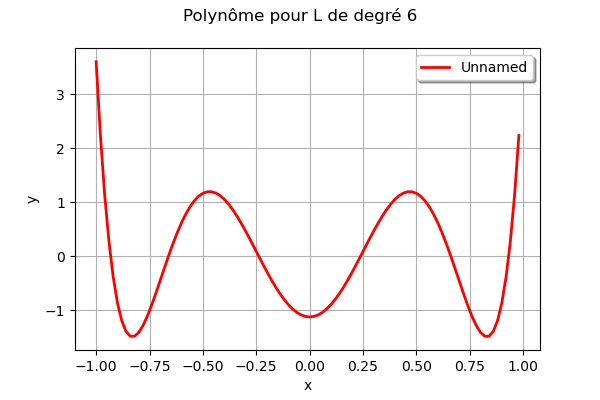

In [19]:
P6 = factory_L.build(6)
graph = P6.draw(Lmin, Lmax, 100)
graph.setTitle("Polynôme pour L de degré 6")
graph

## Exercice 1 : vérifier la récurrence à trois termes pour les polynômes d'Hermite

In [20]:
def evalPolynomialFactory(x, polyfact, degree):
    """
    Evaluates the orthogonal polynomial with given degree.

    The code uses the three-term recurrence:

        P{n+1}(x) = (a0n * x + a1n) * P{n}(x) + a2n * P{n-1}(x)

    Parameters
    ----------
    x : float
        The point where the polynomial must be evaluated.
    polyfact : ot.OrthogonalUniVariatePolynomial()
        A family of orthonormal polynomials.
    degree : int
        The polynomial degree.

    Returns
    -------
    p : float
        The polynomial value at point x.

    """
    if degree == 0:
        p = 1.0
    else:
        pp = 0.0  # Previous : P{n-1}
        pc = 1.0  # Current : Pn
        for n in range(degree):
            # Evalue P{n+1}(x) en fonction de Pn et P{n-1}
            a0, a1, a2 = polyfact.getRecurrenceCoefficients(n)
            p = (a0 * x + a1) * pc + a2 * pp
            pp = pc
            pc = p
    return p

## Solution de l'exercice 1 : vérifier la récurrence à trois termes pour les polynômes d'Hermite

In [21]:
npoints = 5
x = linearSample(-3.0, 3.0, npoints)
for k in range(5):
    print("")
    print("Degree = %d" % (k))
    pk = pofa.build(k)
    for i in range(npoints):
        y = evalPolynomialFactory(x[i, 0], pofa, k)
        ytrue = pk(x[i, 0])
        print("x=%f, y=%f, True y = %f" % (x[i, 0], y, ytrue))


Degree = 0
x=-3.000000, y=1.000000, True y = 1.000000
x=-1.500000, y=1.000000, True y = 1.000000
x=0.000000, y=1.000000, True y = 1.000000
x=1.500000, y=1.000000, True y = 1.000000
x=3.000000, y=1.000000, True y = 1.000000

Degree = 1
x=-3.000000, y=-3.000000, True y = -3.000000
x=-1.500000, y=-1.500000, True y = -1.500000
x=0.000000, y=0.000000, True y = 0.000000
x=1.500000, y=1.500000, True y = 1.500000
x=3.000000, y=3.000000, True y = 3.000000

Degree = 2
x=-3.000000, y=5.656854, True y = 5.656854
x=-1.500000, y=0.883883, True y = 0.883883
x=0.000000, y=-0.707107, True y = -0.707107
x=1.500000, y=0.883883, True y = 0.883883
x=3.000000, y=5.656854, True y = 5.656854

Degree = 3
x=-3.000000, y=-7.348469, True y = -7.348469
x=-1.500000, y=0.459279, True y = 0.459279
x=0.000000, y=-0.000000, True y = -0.000000
x=1.500000, y=-0.459279, True y = -0.459279
x=3.000000, y=7.348469, True y = 7.348469

Degree = 4
x=-3.000000, y=6.123724, True y = 6.123724
x=-1.500000, y=-1.109925, True y = -1

On vérifie que l'on obtient des résultats égaux.

## Exercice 2 : vérification de l'orthornormalité des polynômes


In [22]:
def integrandPiJPiKF(x):
    """
    Evaluates pj(x) * pk(x) * f(x) for the Gaussian PDF at point x.

    This function is the integrand to consider when
    we want to check that the polynomials are orthogonal.

    Parameters
    ----------
    x : ot.Point(1)
        The point.

    Returns
    -------
    y : list(float)
        The integrand value.

    """
    pdf = gaussianRandomVariable.computePDF(x)
    yf = hermitePolynomialJ(x[0]) * hermitePolynomialK(x[0]) * pdf
    return [yf]

gaussianRandomVariable = ot.Normal()
integrandPiJPiKFPy = ot.PythonFunction(1, 1, integrandPiJPiKF)

Pour évaluer l'intégrale, nous proposons d'utiliser la règle de Gauss-Kronrod implémentée dans la classe `GaussKronrodRule`. 

In [23]:
gkr = ot.GaussKronrodRule(ot.GaussKronrodRule.G11K23)
algo = ot.GaussKronrod(1000, 1e-16, gkr)

Il est nécessaire de fixer des bornes finies pour évaluer l'intégrale. Nous savons que la densité de probabilité de la loi gaussienne centrée et réduite est numériquement égale à zéro en dehors de l'intervalle [-38,38].

In [24]:
gaussianRandomVariable.computePDF(ot.Sample([[-38.0], [-37.0], [37.0], [38.0]]))

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=4 dimension=1 data=[[1.09722e-314],[2.12001e-298],[2.12001e-298],[1.09722e-314]]

C'est pour cette raisons que nous fixons ainsi les bornes de l'intervalle d'intégration.

In [25]:
bounds = ot.Interval(-38.0, 38.0)

Le produit scalaire peut alors être calculé avec les instructions :
```python
hermitePolynomialJ = pofa.build(j)
hermitePolynomialK = pofa.build(k)
pscalJK = algo.integrate(integrandPiJPiKFPy, bounds)[0]
```

Réaliser une boucle sur les indices `j` et `k` entre 0 et 5 et évaluer le produit scalaire : qu'observez-vous ?

## Solution de l'exercice 2 : vérification de l'orthornormalité des polynômes

In [26]:
hermitePolynomialJ = pofa.build(0)
hermitePolynomialK = pofa.build(1)
pscalJK = algo.integrate(integrandPiJPiKFPy, bounds)[0]
pscalJK

-1.1926223897340549e-18

In [27]:
degree = 5
for j in range(degree):
    for k in range(j + 1):
        hermitePolynomialJ = pofa.build(j)
        hermitePolynomialK = pofa.build(k)
        pscalJK = algo.integrate(integrandPiJPiKFPy, bounds)[0]
        print("<P%d,P%d> = %f" % (j, k, pscalJK))

<P0,P0> = 1.000000
<P1,P0> = -0.000000
<P1,P1> = 1.000000
<P2,P0> = -0.000000
<P2,P1> = -0.000000
<P2,P2> = 1.000000
<P3,P0> = 0.000000
<P3,P1> = -0.000000
<P3,P2> = -0.000000
<P3,P3> = 1.000000
<P4,P0> = 0.000000
<P4,P1> = -0.000000
<P4,P2> = 0.000000
<P4,P3> = 0.000000
<P4,P4> = 1.000000


On observe que le produit scalaire est nul si les indices sont différents et égal à 1 sinon. 

## Exercice 3 : orthonormalisation d'une densité de probabilité

La classe `AdaptiveStieltjesAlgorithm` propose un algorithme pour générer la base orthonormale associée à une densité de probabilité donnée. Sur le principe, cette classe réalise l'algorithme de Gram-Schmidt pour générer la base orthonormale à partir de la base canonique. L'implémentation repose en fait sur un algorithme plus précis sur le plan numérique, en particulier pour les polynômes de dégré élevés.

L'objectif de cet exercice est de comparer les polynômes obtenus par la classe `AdaptiveStieltjesAlgorithm` pour la loi uniforme avec les polynômes de Legendre.

* Dans un premier temps, on utilise l'algorithme d'orthonormalisation.
  * Créer la variable `measure` contenant une variable uniforme standard.
  * Utiliser la classe `AdaptiveStieltjesAlgorithm` pour créer un algorithme d'orthonormalisation `algo`.
  * Utiliser la classe `StandardDistributionPolynomialFactory` pour créer la variable `pofa` sur cet algorithme.
  * Utiliser la méthode `build` pour afficher les polynômes de degrés 0 à 4 correspondants.
* Dans un second temps, on utilise les polynômes de Legendre.
  * Utiliser la classe `LegendreFactory` pour créer la variable `lefa`.
  * Utiliser la variable `lefa` pour afficher les polynômes de Legendre de degrés 0 à 4 correspondants.
* Comparer les deux résultats : qu'observez-vous ?

## Solution de l'exercice 3 : orthonormalisation d'une densité de probabilité

In [28]:
measure = ot.Uniform()
algo = ot.AdaptiveStieltjesAlgorithm(measure)
pofa = ot.StandardDistributionPolynomialFactory(algo)
for k in range(5):
    print(pofa.build(k))

1
1.73205 * X
-1.11803 + 3.3541 * X^2
-3.96863 * X + 6.61438 * X^3
1.125 - 11.25 * X^2 + 13.125 * X^4


In [29]:
lefa = ot.LegendreFactory()

for k in range(5):
    print(lefa.build(k))

1
1.73205 * X
-1.11803 + 3.3541 * X^2
-3.96863 * X + 6.61438 * X^3
1.125 - 11.25 * X^2 + 13.125 * X^4


On observe que l'on obtient les mêmes polynômes.

## Solution de l'exercice 4 : polynômes orthogonaux pour une variable gaussienne

In [30]:
normal_distribution = ot.Normal(12.0, 3.4)
normal_factory = ot.StandardDistributionPolynomialFactory(normal_distribution)
normal_factory

class=StandardDistributionPolynomialFactory hasSpecificFamily=true specificFamily=class=OrthogonalUniVariatePolynomialFamily implementation=class=HermiteFactory measure=class=Normal name=Normal dimension=1 mean=class=Point name=Unnamed dimension=1 values=[0] sigma=class=Point name=Unnamed dimension=1 values=[1] correlationMatrix=class=CorrelationMatrix dimension=1 implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[1]

On vérifie que la famille de polynômes orthogonaux associés à la variable `N` est la famille des polynômes d'Hermite.

In [31]:
for i in range(5):
    Pi = normal_factory.build(i)
    print(Pi)

1
X
-0.707107 + 0.707107 * X^2
-1.22474 * X + 0.408248 * X^3
0.612372 - 1.22474 * X^2 + 0.204124 * X^4


In [32]:
measure = normal_factory.getMeasure()
measure

class=Normal name=Normal dimension=1 mean=class=Point name=Unnamed dimension=1 values=[0] sigma=class=Point name=Unnamed dimension=1 values=[1] correlationMatrix=class=CorrelationMatrix dimension=1 implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[1]

In [33]:
measure.getRange()

class=Interval name=Unnamed dimension=1 lower bound=class=Point name=Unnamed dimension=1 values=[-7.65063] upper bound=class=Point name=Unnamed dimension=1 values=[7.65063] finite lower bound=[0] finite upper bound=[0]

Puisqu'une variable gaussienne n'est pas bornée, on ne peut pas utiliser `getRange` pour avoir des bornes finies.

In [34]:
ci = measure.computeBilateralConfidenceInterval(0.99)
ci

class=Interval name=Unnamed dimension=1 lower bound=class=Point name=Unnamed dimension=1 values=[-2.57583] upper bound=class=Point name=Unnamed dimension=1 values=[2.57583] finite lower bound=[1] finite upper bound=[1]

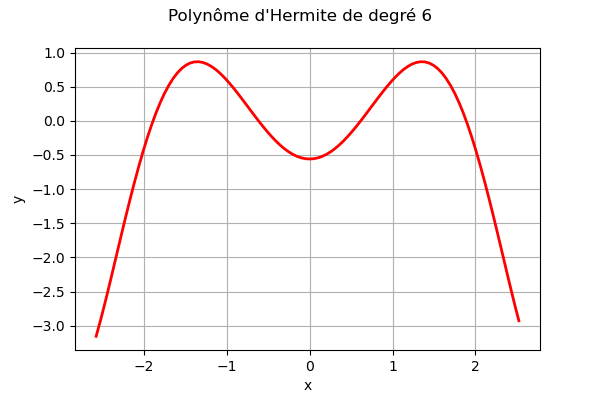

In [35]:
Nmin = ci.getLowerBound()[0]
Nmax = ci.getUpperBound()[0]

P6 = normal_factory.build(6)
graph = P6.draw(Nmin, Nmax, 100)
graph.setTitle("Polynôme d'Hermite de degré 6")
graph.setLegends([""])
graph

## Solution de l'exercice 5 : polynômes orthogonaux pour la variable F

In [37]:
F_para = ot.LogNormalMuSigma(3.0e4, 9.0e3, 15.0e3)  # in N
dist_F = ot.ParametrizedDistribution(F_para)

factory_F = ot.StandardDistributionPolynomialFactory(dist_F)
factory_F

class=StandardDistributionPolynomialFactory hasSpecificFamily=false orthonormalization algorithm=class=OrthonormalizationAlgorithm implementation=class=AdaptiveStieltjesAlgorithm measure=class=LogNormal name=LogNormal dimension=1 muLog=9.46206 sigmaLog=0.554513 gamma=0 monicRecurrenceCoefficients=class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=2 dimension=3 data=[[1,-15000,0],[1,-33144,-8.1e+07]] monicSquaredNorms=class=Point name=Unnamed dimension=2 values=[1,8.1e+07] isElliptical=false

In [38]:
for i in range(5):
    Pi = factory_F.build(i)
    print(Pi)

1
-1.66667 + 0.000111111 * X
2.10868 - 0.000243946 * X + 5.067e-09 * X^2
-2.32967 + 0.000353481 * X - 1.27408e-08 * X^2 + 1.09091e-13 * X^3
2.38177 - 0.000424553 * X + 2.00731e-08 * X^2 - 2.98308e-13 * X^3 + 1.17594e-18 * X^4


In [39]:
measure = factory_F.getMeasure()
measure

class=LogNormal name=LogNormal dimension=1 muLog=9.46206 sigmaLog=0.554513 gamma=0

Pour dessiner le polynôme, on ne peut pas utiliser la méthode `getRange`, car la loi log-normale n'est pas bornée.

In [40]:
measure.getRange()

class=Interval name=Unnamed dimension=1 lower bound=class=Point name=Unnamed dimension=1 values=[0] upper bound=class=Point name=Unnamed dimension=1 values=[894872] finite lower bound=[1] finite upper bound=[0]

In [41]:
ci = measure.computeBilateralConfidenceInterval(0.99)
ci

class=Interval name=Unnamed dimension=1 lower bound=class=Point name=Unnamed dimension=1 values=[3083.23] upper bound=class=Point name=Unnamed dimension=1 values=[53658.4] finite lower bound=[1] finite upper bound=[1]

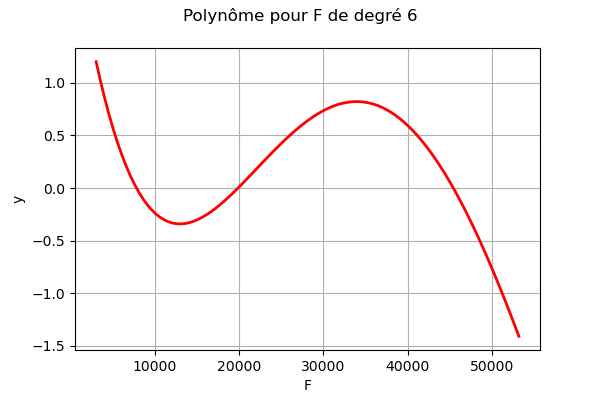

In [42]:
Fmin = ci.getLowerBound()[0]
Fmax = ci.getUpperBound()[0]

P6 = factory_F.build(6)
graph = P6.draw(Fmin, Fmax, 100)
graph.setTitle("Polynôme pour F de degré 6")
graph.setXTitle("F")
graph.setLegends([""])
graph